# Point Pattern Windows

**Author: Serge Rey <sjsrey@gmail.com>**

## Introduction
Windows play several important roles in the analysis of planar point patterns. As we saw in the [introductory notebook](pointpattern.ipynb), the area of the window can be used to develop estimates of the intensity of the point pattern. A window also defines the domain for the point pattern and can support corrections for so-called edge effects in the statistical analysis of point patterns. However, there are different ways to define a window for a point pattern.

This notebook provides an overview of how to work with windows and covers the following:

* [Creating a window](#Creating-a-Window)
* [Window attributes](#Window-Attributes)
* [Window methods](#Window-Methods)
* [Multi-part windows](#Multi-part-Windows)
* [Windows and point pattern intensity revisited](#Windows-and-point-pattern-intensity-revisited)


## Creating a Window

We will first continue on with an example from the [introductory notebook](pointpattern.ipynb). Recall this uses  200 randomly distributed points within the counties of Virginia. Coordinates are for UTM zone 17 N.

In [101]:
import libpysal as ps
import numpy as np
from pointpats import PointPattern

In [102]:
f = ps.examples.get_path('vautm17n_points.shp')
fo = ps.io.open(f)
pp_va = PointPattern(np.asarray([pnt for pnt in fo]))
fo.close()
pp_va.summary()

Point Pattern
200 points
Bounding rectangle [(273959.664381352,4049220.903414295), (972595.9895779632,4359604.85977962)]
Area of window: 216845506675.0557
Intensity estimate for window: 9.223156295311261e-10
               x             y
0  865322.486181  4.150317e+06
1  774479.213103  4.258993e+06
2  308048.692232  4.054700e+06
3  670711.529980  4.258864e+06
4  666254.475614  4.256514e+06


From the summary method we see that the **Bounding Rectangle** is reported along with the **Area of the window** for the point pattern. Two things to note here. 

First, the only argument we passed in to the `PointPattern`s constructor was the array of coordinates for the 200 points. In this case PySAL finds the [minimum bounding box](https://en.wikipedia.org/wiki/Minimum_bounding_rectangle) for the point pattern and uses this as the window.

The second thing to note is that the area of the window in this case is simply the area of the bounding rectangle. Because we are using projected coordinates (UTM) the unit of measure for the area is in square meters.

## Window Attributes

The window is an attribute of the `PointPattern`. It is also an object with its own attributes:

In [103]:
pp_va.window.area

216845506675.0557

In [104]:
pp_va.window.bbox

[273959.664381352, 4049220.903414295, 972595.9895779632, 4359604.85977962]

The bounding box is given in left, bottom, right, top ordering.

In [105]:
pp_va.window.centroid

(623277.8269796579, 4204412.881596957)

In [106]:
pp_va.window.parts

[[(273959.664381352, 4049220.903414295),
  (273959.664381352, 4359604.85977962),
  (972595.9895779632, 4359604.85977962),
  (972595.9895779632, 4049220.903414295),
  (273959.664381352, 4049220.903414295)]]

The `parts` attribute for the `window` is a list of polygons. In this case the window has only a single part and it is a rectangular polygon with vertices listed clockwise in closed cartographic form.

## Window Methods

A window has several basic geometric operations that are heavily used in some of the other modules in the the `Point` package. Most of this is done under the hood and the user typically doesn't see this. However, there can be times when direct access to these method can be handy. Let's explore.


The window supports basic point containment checks:

In [107]:
pp_va.window.contains_point((623277.82697965798, 4204412.8815969583))

True

This also applies to sequences of points:

In [108]:
pnts = ((-623277.82697965798, 4204412.8815969583),
        (623277.82697965798, 4204412.8815969583),
        (1000.01, 200.9))

In [109]:
pnts_in = pp_va.window.filter_contained(pnts)
pnts_in

[array([ 623277.82697966, 4204412.88159696])]

## Multi-part Windows

Thus far our window was a simple bounding box. There many instances when the relevant containing geometry for a point pattern is more complex. Examples include multi-part polygons and polygons with holes.

Here we construct such a window, one with two parts and one hole.

In [110]:
parts = [[(0.0, 0.0), (0.0, 10.0), (10.0, 10.0), (10.0, 0.0)],
         [(11.,11.), (11.,20.), (20.,20.), (20.,11.)]]
holes = [[(3.0,3.0), (6.0, 3.0), (6.0, 6.0), (3.0, 6.0)]]

We will plot this using matplotlib to get a better understanding of the challenges that this type of window presents for statistical analysis of the associated point pattern.

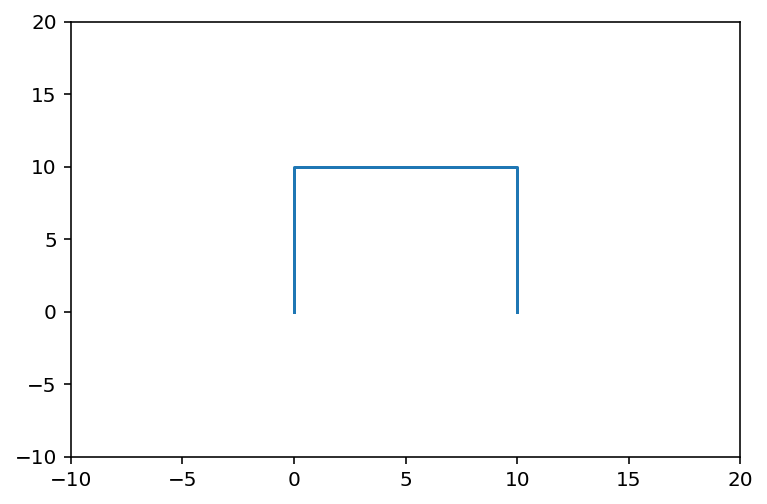

In [111]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt


p0 = np.asarray(parts[0])
plt.plot(p0[:,0], p0[:,1])
plt.xlim(-10,20)
t = plt.ylim(-10,20) # silence the output of ylim

Not, quite what we wanted, as the first part of our multi-part polygon is a ring, but it was not encoded in closed cartographic form:

In [112]:
p0

array([[ 0.,  0.],
       [ 0., 10.],
       [10., 10.],
       [10.,  0.]])

We can fix this with a helper function from the `window` module:

In [113]:
from pointpats.window import to_ccf
print(parts[0])
print(to_ccf(parts[0])) #get closed ring

[(0.0, 0.0), (0.0, 10.0), (10.0, 10.0), (10.0, 0.0)]
[(0.0, 0.0), (0.0, 10.0), (10.0, 10.0), (10.0, 0.0), (0.0, 0.0)]


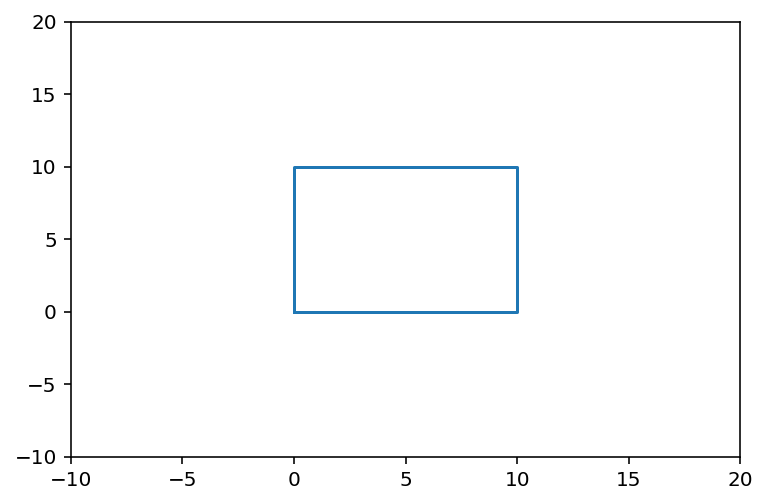

In [114]:
from pointpats.window import to_ccf
p0 = np.asarray(to_ccf(parts[0]))
plt.plot(p0[:,0], p0[:,1])
plt.xlim(-10,20)
t=plt.ylim(-10,20)

Now we can print all the rings composing our window: two exterior rings, and one hole:

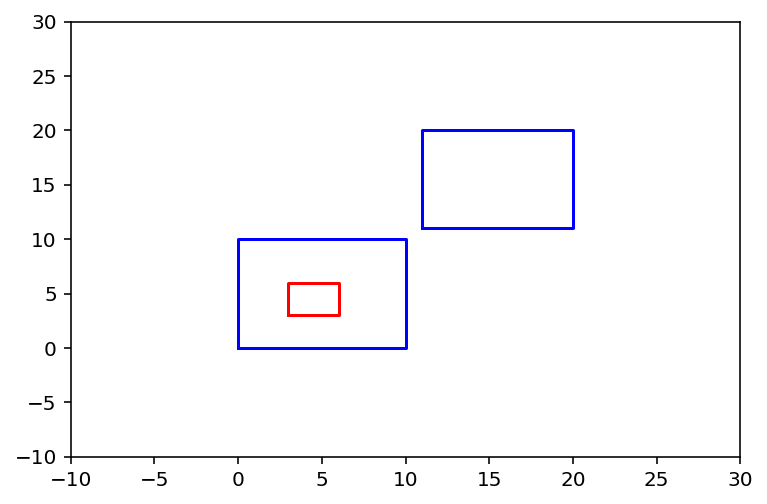

In [115]:
for part in parts:
    part = np.asarray(to_ccf(part))
    plt.plot(part[:,0], part[:,1], 'b')
for hole in holes:
    hole = np.asarray(to_ccf(hole))
    plt.plot(hole[:,0], hole[:,1], 'r')
plt.xlim(-10,30)
t = plt.ylim(-10,30)

The red hole is associated with the first exterior ring.

With this visual representation, consider the problem of testing whether or not this multi-part window contains one or more points in a sequence:

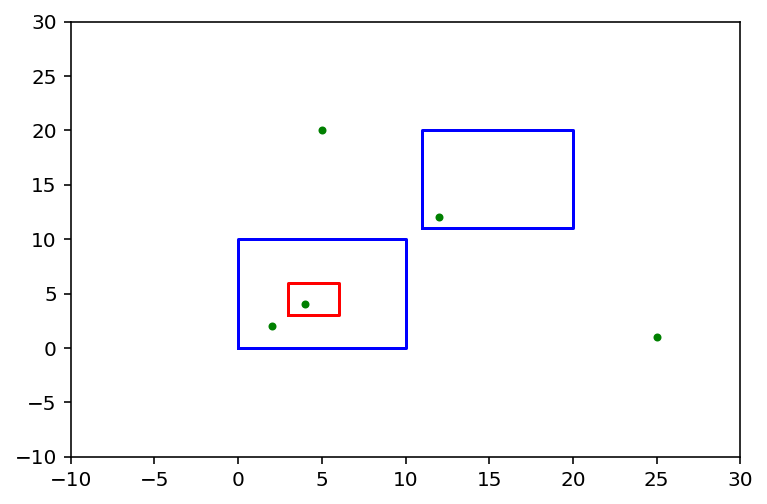

In [116]:
pnts = [(12,12), (4,4), (2,2), (25,1), (5,20)]
for pnt in pnts:
    plt.plot(pnt[0], pnt[1], 'g.')

for part in parts:
    part = np.asarray(to_ccf(part))
    plt.plot(part[:,0], part[:,1], 'b')
for hole in holes:
    hole = np.asarray(to_ccf(hole))
    plt.plot(hole[:,0], hole[:,1], 'r')
plt.xlim(-10,30)
t = plt.ylim(-10,30)

Of the five points two are clearly outside of both of the exterior rings. The three remaining points are each contained in one of the bounding boxes for an exterior ring. However, one of these points is also contained in the hole ring, and thus is not contained in the exterior ring associated with that hole.

We can create a Window object from the parts and holes to demonstrate how to evaluate these containment checks.

In [117]:
from pointpats import Window
window = Window(parts, holes)

In [118]:
window.parts

[[(0.0, 0.0), (0.0, 10.0), (10.0, 10.0), (10.0, 0.0), (0.0, 0.0)],
 [(11.0, 11.0), (11.0, 20.0), (20.0, 20.0), (20.0, 11.0), (11.0, 11.0)]]

In [119]:
window.holes

[[(3.0, 3.0), (3.0, 6.0), (6.0, 6.0), (6.0, 3.0), (3.0, 3.0)]]

In [120]:
window.bbox

[0.0, 0.0, 20.0, 20.0]

In [121]:
window.area

172.0

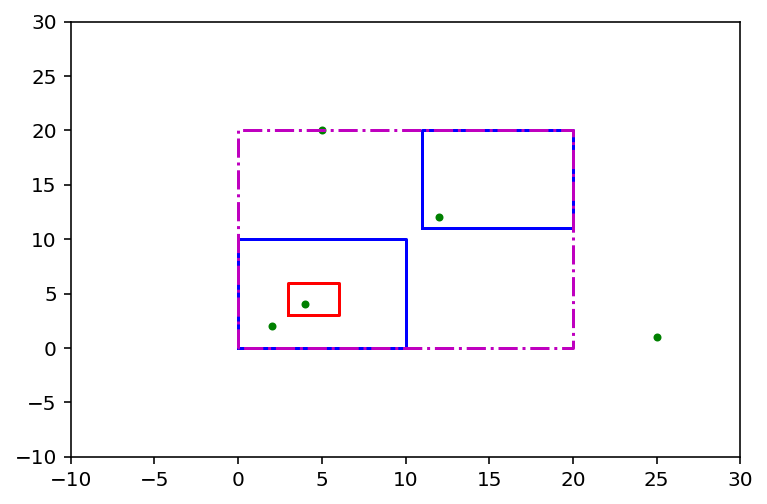

In [122]:
pnts = [(12,12), (4,4), (2,2), (25,1), (5,20)]
for pnt in pnts:
    plt.plot(pnt[0], pnt[1], 'g.') #plot the five points in green

for part in parts:
    part = np.asarray(to_ccf(part))
    plt.plot(part[:,0], part[:,1], 'b') #plot "parts" in blue
for hole in holes:
    hole = np.asarray(to_ccf(hole))
    plt.plot(hole[:,0], hole[:,1], 'r') #plot "hole" in red 
    
from pointpats.window import poly_from_bbox
poly = np.asarray(poly_from_bbox(window.bbox).vertices)
plt.plot(poly[:,0], poly[:,1], 'm-.') #plot the minimum bounding box in magenta

plt.xlim(-10,30)
t = plt.ylim(-10,30)

Here we have extended the figure to include the bounding box for the multi-part window (in cyan). Now we can call the `filter_contained` method of the window on the point sequence:

In [123]:
pin = window.filter_contained(pnts)
pin

[array([12, 12]), array([2, 2])]

This was a lot of code just to illustrate that the methods of a window can be used to identify topological relationships between points and the window's constituent parts. Let's turn to a less contrived example to see this in action.

Here we will make use of PySAL's [shapely extension](https://pysal.readthedocs.org/en/latest/users/tutorials/shapely.html) to create a multi-part window from the county shapefile for Virgina.

In [124]:
from libpysal.cg import shapely_ext
import numpy as np
from pointpats.window import poly_from_bbox, as_window, Window
import libpysal as ps


In [125]:
va = ps.io.open(ps.examples.get_path("vautm17n.shp")) #open "vautm17n" polygon shapefile
polys = [shp for shp in va]
vapnts = ps.io.open(ps.examples.get_path("vautm17n_points.shp")) #open "vautm17n_points" point shapefile
points = [shp for shp in vapnts]

In [126]:
print(len(polys))

136


The county shapefile `vautm17n.shp` has 136 shapes of the `polygon` type. Some of these are composed of multiple-rings and holes to reflect the [interesting history](https://en.wikipedia.org/wiki/List_of_counties_in_Virginia) of political boundaries in that State.
Fortunately, with our window class we can handle these. We will come back to this shortly.

First we are going to build up a realistic window for our point pattern based on a *cascaded union* made possible via [Shapely](https://pypi.python.org/pypi/Shapely) through the [PySAL shapely extension](https://pysal.readthedocs.org/en/latest/users/tutorials/shapely.html).

In [127]:
cu = shapely_ext.cascaded_union(polys)

This creates a PySAL Polygon:

In [128]:
type(cu)

libpysal.cg.shapes.Polygon

We can construct a Window from this polygon instance using the helper function `as_window`:

In [129]:
w = as_window(cu)

In [130]:
w.holes

[[]]

In [131]:
len(w.parts)

3

The window has three parts consisting of the union of mainland counties and two "island" parts associated with Accomack and Northampton counties and has no holes.

Since this a window, we can access its properties:

In [132]:
w.bbox

[260694.99205079858, 4044845.4484747574, 1005496.0048517315, 4370839.043748417]

In [133]:
w.centroid

(689097.7340935213, 4155195.0497352206)

In [134]:
w.contains_point(w.centroid)

True

So the centroid for our new window is contained by the window.  Such a result is not guaranteed as the geometry of the window could be complex such that the centroid falls outside of the window.

Let's continue on with a more interesting query. Since we know the window centroid is contained in the Window, we can find which individual county contains the centroid. 

Our strategy is a simple one to illustrate the useful nature of the Window. We will create a sequence of Windows, one for each county and use them to carry out a containment test.

In [135]:
#create a window for each of the individual counties in the state
windows = [as_window(county) for county in polys]

In [136]:
#check each county for containment of the window's centroid
cent_poly = [ (i, county) for i,county in enumerate(windows) if county.contains_point(w.centroid)]
cent_poly

[(67, <pointpats.window.Window at 0x1310fcf28>)]

In [137]:
i, cent_poly = cent_poly[0]

In [138]:
cent_poly.bbox

[674997.5183093206, 4119217.2472937624, 713300.2226730094, 4159075.43995212]

What we did here was create a window for each of the individual counties in the state. With these in hand we checked each one for containment of the window's centroid. The result is we see the window (count) with index 67 is the only one that contains the centroid point.

The point of this exercise is not to use an inefficient brute force exhaustive search to find this county. There are more efficient spatial indices in PySAL that we could use for such a query. Rather, we wanted to explicitly check each window to ensure that only one contained the centroid.

As we will see in elsewhere in this series of notebooks, this type of decomposition can support highly flexible types of spatial analysis.

## Windows and point pattern intensity revisited

Returning to the central use of Windows, we saw in the [introductory notebook](pointpattern.ipynb) that the area of the Window is used to form the estimate of intensity for the point pattern:

In [139]:
f = ps.examples.get_path('vautm17n_points.shp') #open "vautm17n_points" point shapefile
fo = ps.io.open(f)
pnts = np.asarray([pnt for pnt in fo])
fo.close()
pp_va = PointPattern(pnts)
pp_va.summary()

Point Pattern
200 points
Bounding rectangle [(273959.664381352,4049220.903414295), (972595.9895779632,4359604.85977962)]
Area of window: 216845506675.0557
Intensity estimate for window: 9.223156295311261e-10
               x             y
0  865322.486181  4.150317e+06
1  774479.213103  4.258993e+06
2  308048.692232  4.054700e+06
3  670711.529980  4.258864e+06
4  666254.475614  4.256514e+06


Here the default is to form the minimum bounding rectangle and use that as the window for the point pattern and, in turn, to implment the intesity estimation.

We can override the default by passing a window object in to the constructor for the point pattner. Here we use our window that was formed from the county cascading union above:

In [140]:
pp_va_union = PointPattern(pnts, window=w)
pp_va_union.summary()

Point Pattern
200 points
Bounding rectangle [(273959.664381352,4049220.903414295), (972595.9895779632,4359604.85977962)]
Area of window: 103195696155.68987
Intensity estimate for window: 1.9380653210407425e-09
               x             y
0  865322.486181  4.150317e+06
1  774479.213103  4.258993e+06
2  308048.692232  4.054700e+06
3  670711.529980  4.258864e+06
4  666254.475614  4.256514e+06


Here, the window is redefined. Thus, window related attributes **Area of window** and **Intensity estimate for window** are changed. However, the **Bounding rectangle** remains unchanged since it is not relavant to the definition of window.

Close examination of the summary report reveals that while the bounding rectangles for the two point pattern instances are identical (as they should be), the area of the windows are substantially different:

In [141]:
pp_va.window.area / pp_va_union.window.area

2.1013037825521717

as are the intensity estimates:

In [142]:
pp_va.lambda_window / pp_va_union.lambda_window

0.47589501732368955